# Exercise 6: ARMA and GARCH models

**_Group: Ducray, Razanajatovo_**

Please find below our code and empirical work regarding Roche's price returns.

In [15]:
# Dataframe, maths and plotting packages
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

#from itertools import product
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.api import tsa
from scipy import signal
import scipy.io as sio

In [3]:
########### Load and prepare data ###########
# Import data
df = pd.read_excel('Exercise6.xlsx',index_col=0)
# Sort data in chronological order
df = df.sort_values(by='Date', ascending=True)
# Compute the daily log returns on Roche stock prices
df_logret = np.log1p(df['Last Price'].pct_change().iloc[1:])*100
df_logret

Date
2017-12-08   -0.745654
2017-12-11    0.041571
2017-12-12    0.456148
2017-12-13    0.000000
2017-12-14    0.000000
                ...   
2022-08-25    0.565062
2022-08-26   -0.848795
2022-08-29   -0.744676
2022-08-30    0.634118
2022-08-31   -0.316556
Name: Last Price, Length: 1186, dtype: float64

In [1]:
########### Visual representation ###########
# Check the stock price's fluctuation
plt.subplot(1, 2, 1)
plt.plot(df['Last Price'])
plt.title("Roche Stock Prices")
plt.xlabel('Time')
plt.ylabel('Price')
# Check the evolution of log-returns
plt.subplot(1, 2, 2)
plt.plot(df_logret)
plt.title("Roche Stock Log-returns")
plt.xlabel('Time')
plt.ylabel('Log-Return')
# Identify trends

NameError: name 'plt' is not defined

In [5]:
########### Review Assumption ###########

# Test for stationarity using the ADF test
test = adfuller(df_logret)
df_adf = pd.DataFrame(index=['Test Statistic Value', "p-value", "Lags Used", "Number of Observations Used","Critical Value(1%)","Critical Value(5%)","Critical Value(10%)"],columns=['Output'])
df_adf['Output']['Test Statistic Value'] = test[0]
df_adf['Output']['p-value'] = test[1]
df_adf['Output']['Lags Used'] = test[2]
df_adf['Output']['Number of Observations Used'] = test[3]
df_adf['Output']['Critical Value(1%)'] = test[4]['1%']
df_adf['Output']['Critical Value(5%)'] = test[4]['5%']
df_adf['Output']['Critical Value(10%)'] = test[4]['10%']
df_adf
# The null hypothesis is not rejected: the process is stationary (pvalue below thresholds & t-stat < critical value)
# No need to differentiate or detrend

,Output
Test Statistic Value,-34.337771
p-value,0.0
Lags Used,0
Number of Observations Used,1185
Critical Value(1%),-3.43588
Critical Value(5%),-2.863982
Critical Value(10%),-2.56807


In [6]:
########### Split data into training and test set  ###########
df_train = df_logret.iloc[:round(len(df_logret)*0.7)]
df_test = df_logret.iloc[round(len(df_logret)*0.7):]

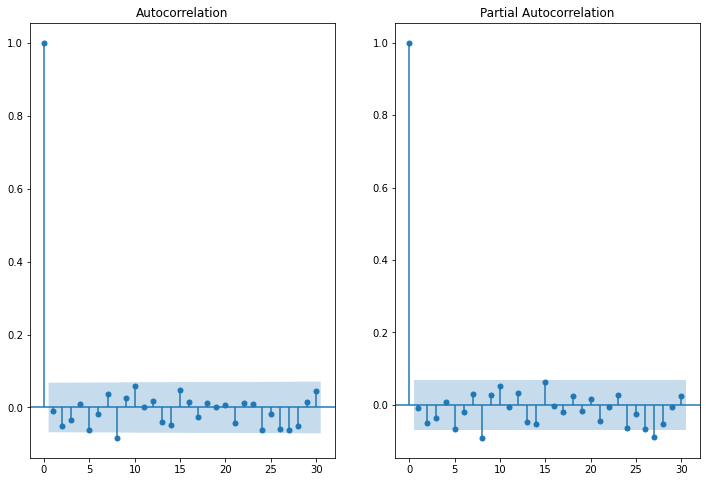

In [7]:
########### Analyze ACF/PACF to identify parameters ###########

# ACF plot with 95% confidence interval
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(121)
fig = sm.graphics.tsa.plot_acf(df_train, alpha=0.05,lags=30, ax=ax1)
# PACF plot with 95% confidence interval
ax2 = fig.add_subplot(122)
fig = sm.graphics.tsa.plot_pacf(df_train, alpha=0.05,lags=30, ax=ax2)
# Can't graphically infer any AR or MA process nor the parameters of the model. 
# It makes sense, random walks are best at forecasting stock prices.
# Let's compute optimal parameters using AIC/BIC criterion.

In [8]:
########### Estimate ARMA Parameters ###########

from itertools import product
import statsmodels.api as sm

ar_order = [0, 1, 2, 3]
ma_order = [0, 1, 2, 3]
arma_res = [list(orders) for orders in product(ar_order, ma_order)]

for order in arma_res:
    print('fitting: ar:{} - ma:{}'.format(*order)) 
    try:
        arma_model  = sm.tsa.ARMA(df_logret, order=order).fit(method='mle', disp=-1)
        order.extend([arma_model.aic / 1e3, arma_model.bic / 1e3])
    except Exception as exception:
        print(exception.__str__())
        order.extend([np.NaN, np.NaN])
    
res = pd.DataFrame(arma_res, columns = ['ar_order', 'ma_order', 'aic', 'bic'])
print('criterion\n', res)
# As expected, the best model appears to be an ARMA(0,0) - a random walk. 

fitting: ar:0 - ma:0
fitting: ar:0 - ma:1
fitting: ar:0 - ma:2


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency

fitting: ar:0 - ma:3
fitting: ar:1 - ma:0


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


fitting: ar:1 - ma:1
fitting: ar:1 - ma:2


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


fitting: ar:1 - ma:3


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


fitting: ar:2 - ma:0
fitting: ar:2 - ma:1


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


fitting: ar:2 - ma:2


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


fitting: ar:2 - ma:3


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


fitting: ar:3 - ma:0
fitting: ar:3 - ma:1


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


fitting: ar:3 - ma:2


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


fitting: ar:3 - ma:3


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


criterion
     ar_order  ma_order       aic       bic
0          0         0  3.932256  3.942413
1          0         1  3.934252  3.949487
2          0         2  3.934326  3.954640
3          0         3  3.934897  3.960289
4          1         0  3.934253  3.949488
5          1         1  3.936108  3.956422
6          1         2  3.935407  3.960799
7          1         3  3.936622  3.967092
8          2         0  3.934275  3.954588
9          2         1  3.935369  3.960761
10         2         2  3.937347  3.967817
11         2         3  3.935034  3.970582
12         3         0  3.935016  3.960408
13         3         1  3.936795  3.967265
14         3         2  3.935183  3.970731
15         3         3  3.934883  3.975509


In [9]:
########### Confirm the best ARMA Parameters using BIC ###########

sm.tsa.arma_order_select_ic(df_train,max_ar=6,max_ma=6,ic='bic')['bic_min_order']
# Suggest using an ARMA(0,0) 

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


(0, 0)

In [20]:
########### Fit the model ###########

from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df_train,order=(0,0,0))
model_fit = model.fit()
model_fit.summary()

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Last Price   No. Observations:                  830
Model:                          ARIMA   Log Likelihood               -1385.082
Date:                Thu, 22 Dec 2022   AIC                           2774.164
Time:                        12:30:32   BIC                           2783.607
Sample:                             0   HQIC                          2777.785
                                - 830                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0266      0.045      0.588      0.557      -0.062       0.115
sigma2         1.6482      0.049     33.898      0.000       1.553       1.743
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):               503.57
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               2.35   Skew:                            -0.43
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [25]:
########### Fit the data ###########  

order = [0,0,0]
start_date = len(df_train)
end_date = start_date + len(df_test) - 1

# Predictions for t+20
forecast = model_fit.forecast(start_date, end_date, typ = 'levels').rename("Predictions")

# plot predictions and actual values
predictions.plot(legend = True)
df_test.plot(legend = True)

TypeError: forecast() takes from 1 to 2 positional arguments but 3 were given

In [19]:
forecasts

[               fixed
 Date                
 2021-04-08  5.723098
 2021-04-09  5.735107
 2021-04-12  5.747117
 2021-04-13  5.759126
 2021-04-14  5.771135
 ...              ...
 2022-08-25  9.938315
 2022-08-26  9.950324
 2022-08-29  9.962333
 2022-08-30  9.974342
 2022-08-31  9.986352
 
 [356 rows x 1 columns]]